# IoT based gesture recognition 
## Gesture based home automation

This notebook is a poc for gesture based home automation - controlling the various appliances at home with gestures.

Gestures are mapped to the corresponding accelerometer and gyroscope values recorded during motion. Here, we have accelerometer and gyroscope values along x, y, z axes recorded 100 times for one gesture, i.e, 600 data points for one gesture.

Dataset: The sensor values were recorded using an app (github link [here](https://github.com/AyishaR/Sensor_data_app)) and consolidates using csv.

Algorithm: A tensorflow deep learning model with relu and softmax activations was used.

![gesture](https://images.unsplash.com/photo-1574676122993-cd7fcf7f9030?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60)

<span>Photo by <a href="https://unsplash.com/@adriensking?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Adrien King</a> on <a href="https://unsplash.com/s/photos/gesture?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

In [47]:
import pandas as pd
import csv
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import normalize, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import urllib

List of gestures and the various categories for reference. 

Here, count refers to moving to the next iinstance of the appliance (eg, countIncrease - moving from fan1 to fan2, countDecrease - moving from fan2 to fan1) and next refers to choosing the next appliance.

In [3]:
gesture_key = {}
gesture_key["appliance"] = ["light", "fan"]
gesture_key["operation"] = ["switch", "increase", "decrease"]
gesture_key["count"] = ["countIncrease", "countDecrease"]
gesture_key["next"] = ["next"]


gestures = []
for x in gesture_key:
    gestures.extend(gesture_key[x])

print(gestures)

['light', 'fan', 'switch', 'increase', 'decrease', 'countIncrease', 'countDecrease', 'next']


Creating .csv from the .txt obtained from the app.

In [ ]:
'''
#gestures = []
with open('/content/gesture25.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    for fn in os.listdir('/content/gesture'):
        print(fn)
        #gestures.append(fn[:-4])
        f = open('/content/gesture/' + fn)
        lines = f.readlines()
        print(len(lines))
        for line in lines:
            line = line[:-1]
            csvwriter.writerow(line.split(' '))
#print(gestures)

d25 = pd.read_csv('/content/gesture25.csv')

d25 = d25[d25['Gesture'] != 'Gesture'].reset_index().drop('index', axis = 'columns')
print(d25)
'''

In [ ]:
# d25.describe()

In [4]:
d25 = pd.read_csv('/content/gesture60_8.csv')

Normalize and shuffle

In [5]:
d25[d25.columns[:-1]] = normalize(d25[d25.columns[:-1]])
d25 = d25.sample(frac=1, random_state=13).reset_index(drop = True)
d25

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,Gesture
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,0.024808,0.002097,-0.001888,0.001117,0.082947,-0.008077,0.024808,0.002097,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,next
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,0.000335,-0.000426,-0.000641,0.006711,0.096712,0.014566,0.000335,-0.000426,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,countDecrease
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,0.000269,0.000499,-0.000634,0.002594,0.103265,-0.009390,0.000269,0.000499,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,light
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.001582,0.000178,-0.000643,-0.007182,0.098363,0.024753,-0.001582,0.000178,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,countIncrease
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,0.000294,-0.001089,-0.000150,0.001877,0.090475,-0.002605,0.000294,-0.001089,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,-0.000150,-0.

# Visualization

In [6]:
data = pd.DataFrame(d25)

In [7]:
col = ['ax','ay','az','gx','gy','gz']*100
col.append('Gesture')
data.columns = col

In [8]:
def extract(gesture,data_dict):
    k = data[data["Gesture"]==gesture].shape[0]
    for j in range(0,k):
        if j == 0:
            data_dict[gesture] = data[data['Gesture']==gesture].iloc[0:1,0:6]
        else:
            data_dict[gesture] = data_dict[gesture].append(data[data['Gesture']==gesture].iloc[j:j+1,0:6])
        for i in range(6,600,6):
            data_dict[gesture] = data_dict[gesture].append(data[data['Gesture']==gesture].iloc[j:j+1,i:i+6])

In [9]:
data_dict = {}
for i in gestures:
    extract(i,data_dict)
    #print(data_dict[i].head())
#data_dict

In [10]:
def visulaize(type, gesture):
    for i in gestures:
        title = type.upper()+' for \"'+i.upper()+'\" gesture'
        plt.title(title)
        if type == 'acceleration':
            index = range(1, len(data_dict[i]['ax']) + 1)
            plt.plot(index, data_dict[i]['ax'], 'g.', label='x', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['ay'], 'b.', label='y', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['az'], 'r.', label='z', linestyle='solid', marker=',')

        if type == 'gyro':
            index = range(1, len(data_dict[i]['ax']) + 1)
            plt.plot(index, data_dict[i]['gx'], 'g.', label='x', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['gy'], 'b.', label='y', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['gz'], 'r.', label='z', linestyle='solid', marker=',')

        plt.legend()
        plt.show()

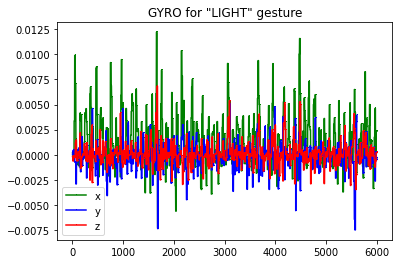

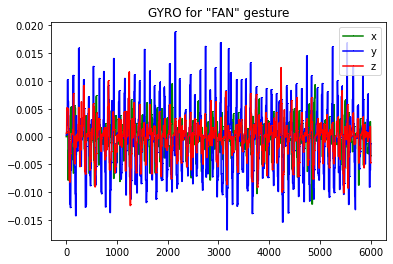

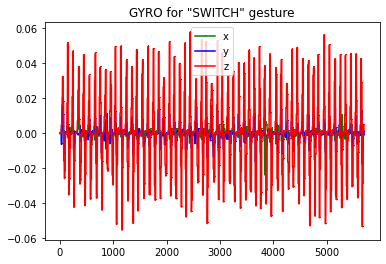

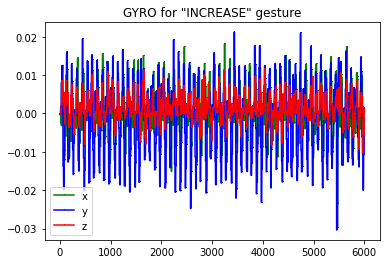

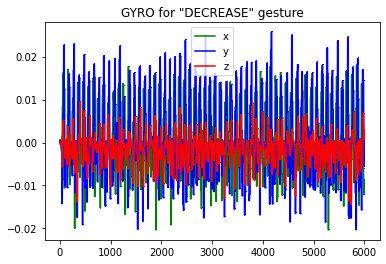

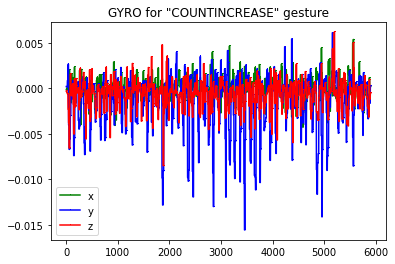

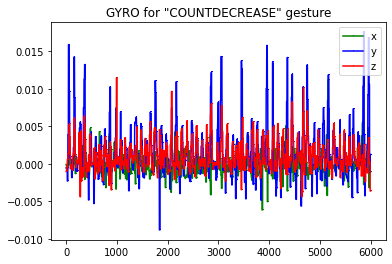

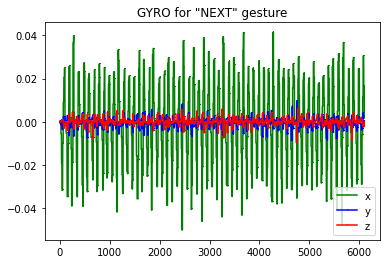

In [11]:
visulaize('gyro', gestures)

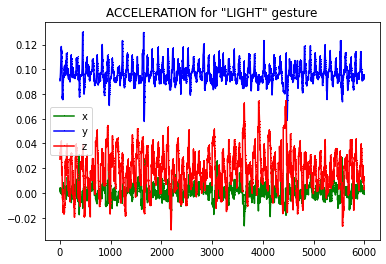

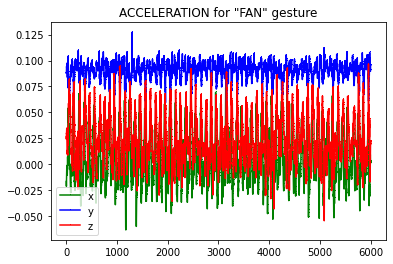

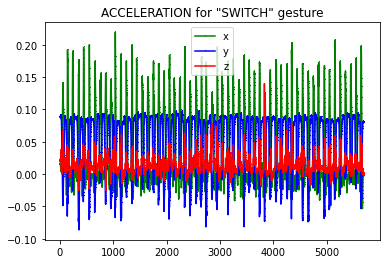

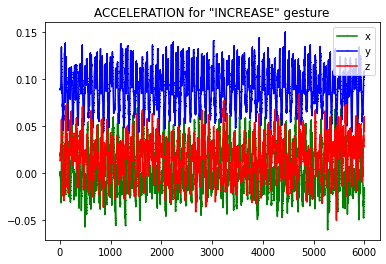

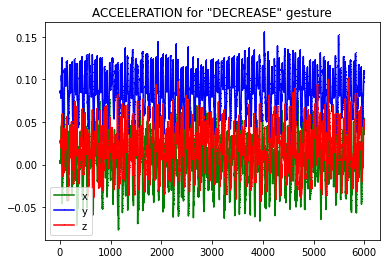

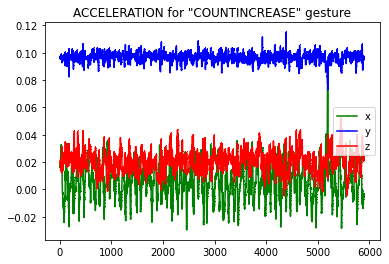

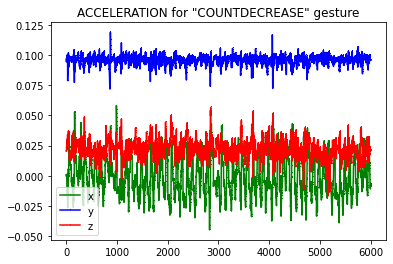

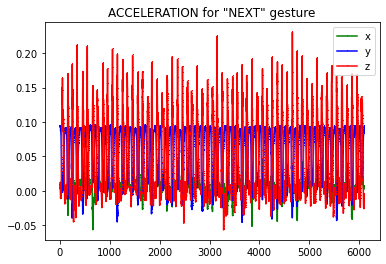

In [12]:
visulaize('acceleration', gestures)

Acceleration plot of 'countIncrease' has an outlier.

Identifying and removing it.


In [20]:
outlier = data_dict['countIncrease'][data_dict['countIncrease']['ax'] > 0.06]
print(outlier)

outlier_index = outlier.index.unique().values

d25 = d25.drop(outlier_index).reset_index(drop = True)

           ax        ay        az        gx        gy        gz
421  0.061794  0.082124  0.010391  0.000595  0.000707 -0.000647
421  0.073243  0.082884  0.017196  0.000595  0.000707 -0.000647
421  0.086864  0.083204  0.017766  0.000595  0.000707 -0.000647
421  0.085522  0.082052  0.012932  0.000595  0.000707 -0.000647
421  0.085581  0.077136  0.009168  0.000595  0.000707 -0.000647
421  0.085581  0.077136  0.009168 -0.000697 -0.000800  0.006152
421  0.088123  0.084677  0.007743 -0.000697 -0.000800  0.006152
421  0.084608  0.080722  0.012517 -0.000697 -0.000800  0.006152
421  0.080439  0.075770  0.015783 -0.000697 -0.000800  0.006152
421  0.079596  0.072789  0.021483 -0.000697 -0.000800  0.006152
421  0.078682  0.078228  0.029547 -0.000697 -0.000800  0.006152
421  0.067530  0.080188  0.034677 -0.000697 -0.000800  0.006152


In [21]:
d25

,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,...,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,Gesture
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,0.024808,0.002097,-0.001888,0.001117,0.082947,-0.008077,0.024808,0.002097,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,next
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,0.000335,-0.000426,-0.000641,0.006711,0.096712,0.014566,0.000335,-0.000426,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,countDecrease
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,0.000269,0.000499,-0.000634,0.002594,0.103265,-0.009390,0.000269,0.000499,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,light
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.001582,0.000178,-0.000643,-0.007182,0.098363,0.024753,-0.001582,0.000178,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,countIncrease
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,0.000294,-0.001089,-0.000150,0.001877,0.090475,-0.002605,0.000294,-0.001089,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,-0.000150,-0.000919,0.089743,-0.005857,0.00

In [22]:
d25.to_csv('gesture60_8_.csv', index = False)

One hot encoding the labels

In [23]:
y_df = pd.get_dummies(d25.Gesture)[gestures]
print(y_df)
print(np.array(y_df)[0].shape)

     light  fan  switch  increase  decrease  countIncrease  countDecrease  next
0        0    0       0         0         0              0              0     1
1        0    0       0         0         0              0              1     0
2        1    0       0         0         0              0              0     0
3        0    0       0         0         0              1              0     0
4        1    0       0         0         0              0              0     0
..     ...  ...     ...       ...       ...            ...            ...   ...
471      0    0       0         0         0              1              0     0
472      0    0       1         0         0              0              0     0
473      0    0       0         0         0              0              1     0
474      0    0       0         0         0              0              0     1
475      0    1       0         0         0              0              0     0

[476 rows x 8 columns]
(8,)


In [24]:
df = pd.concat([d25, y_df], axis=1)
df.head()

,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,...,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,Gesture,light,fan,switch,increase,decrease,countIncrease,countDecrease,next
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,next,0,0,0,0,0,0,0,1
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,countDecrease,0,0,0,0,0,0,1,0
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,light,1,0,0,0,0,0,0,0
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,countIncrease,0,0,0,0,0,1,0,0
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,-0.000150,-0.000919,0.089743,-0.005857,0.000294,-0.001089,-0.000150,light,1,0,0,0,0,0,0,0


In [25]:
train_count = int(0.8*len(df))
test_count = len(df) - train_count
print(train_count, test_count)

x_train, y_train = np.array(df)[:train_count, :600].astype('float32'), np.array(df)[:train_count, -(len(gestures)):].astype('int64')
x_test, y_test = np.array(df)[train_count:, :600].astype('float32'), np.array(df)[train_count:, -(len(gestures)):].astype('int64')

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

380 96
(380, 600) (380, 8) (96, 600) (96, 8)


In [26]:
x_train[0].shape

(600,)

# Model

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation="relu", input_shape = (600,)))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(len(gestures), activation="softmax"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               307712    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 382,152
Trainable params: 382,152
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
model.fit(x_train, y_train, epochs = 16, batch_size = 8)

Epoch 1/16
48/48 [==============================] - 0s 2ms/step - loss: 1.5944 - accuracy: 0.5868
Epoch 2/16
48/48 [==============================] - 0s 2ms/step - loss: 0.4740 - accuracy: 0.8842
Epoch 3/16
48/48 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9605
Epoch 4/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0900 - accuracy: 0.9842
Epoch 5/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9921
Epoch 6/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0473 - accuracy: 0.9895
Epoch 7/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9947
Epoch 8/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0239 - accuracy: 0.9947
Epoch 9/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.9974
Epoch 10/16
48/48 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 11/16
48/48 [

In [31]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.1253 - accuracy: 0.9479


[0.12527960538864136, 0.9479166865348816]

# Tiny model

In [57]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation="relu", input_shape = (600,)))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
model.add(tf.keras.layers.Dense(len(gestures), activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                9616      
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_27 (Dense)             (None, 8)                 40        
Total params: 9,828
Trainable params: 9,828
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(x_train, y_train, epochs = 128, batch_size = 16)
print("\n Test set")
model.evaluate(x_test, y_test)

Epoch 1/128
24/24 [==============================] - 0s 1ms/step - loss: 2.0770 - accuracy: 0.1184
Epoch 2/128
24/24 [==============================] - 0s 1ms/step - loss: 2.0597 - accuracy: 0.1895
Epoch 3/128
24/24 [==============================] - 0s 1ms/step - loss: 2.0250 - accuracy: 0.2447
Epoch 4/128
24/24 [==============================] - 0s 1ms/step - loss: 1.9729 - accuracy: 0.2605
Epoch 5/128
24/24 [==============================] - 0s 1ms/step - loss: 1.9091 - accuracy: 0.2579
Epoch 6/128
24/24 [==============================] - 0s 1ms/step - loss: 1.8415 - accuracy: 0.2816
Epoch 7/128
24/24 [==============================] - 0s 1ms/step - loss: 1.7797 - accuracy: 0.3263
Epoch 8/128
24/24 [==============================] - 0s 1ms/step - loss: 1.7248 - accuracy: 0.3658
Epoch 9/128
24/24 [==============================] - 0s 1ms/step - loss: 1.6709 - accuracy: 0.4789
Epoch 10/128
24/24 [==============================] - 0s 1ms/step - loss: 1.6239 - accuracy: 0.4421
Epoch 11/

[0.2862851917743683, 0.96875]

In [59]:
y_pred = model.predict(x_test)

for i in range(len(y_pred)):
    m = max(y_pred[i])
    j = np.where(y_pred[i] == m)[0][0]
    k = np.where(y_test[i] == 1)[0][0]
    if(j!=k):
        print("------- Mismatch -------")
    print("Actual: " + gestures[k] + "\nPredicted: " + gestures[j] + "\nConfidence: " + str(m) + "\n")

Actual: increase
Predicted: increase
Confidence: 0.9869695

Actual: increase
Predicted: increase
Confidence: 0.5093954

Actual: decrease
Predicted: decrease
Confidence: 0.96171474

Actual: next
Predicted: next
Confidence: 0.9845346

Actual: next
Predicted: next
Confidence: 0.9982272

------- Mismatch -------
Actual: countIncrease
Predicted: countDecrease
Confidence: 0.43365732

Actual: light
Predicted: light
Confidence: 0.53091055

------- Mismatch -------
Actual: increase
Predicted: countIncrease
Confidence: 0.93102264

Actual: increase
Predicted: increase
Confidence: 0.9904018

Actual: switch
Predicted: switch
Confidence: 0.9997819

Actual: fan
Predicted: fan
Confidence: 0.9966499

Actual: light
Predicted: light
Confidence: 0.52399945

Actual: switch
Predicted: switch
Confidence: 0.99937147

Actual: light
Predicted: light
Confidence: 0.52411705

Actual: switch
Predicted: switch
Confidence: 0.9997044

Actual: countDecrease
Predicted: countDecrease
Confidence: 0.60120493

Actual: fan
P

In [61]:
model.save('gestureTinyModel.h5')

In [62]:
model = tf.keras.models.load_model('gestureTinyModel.h5')

In [63]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.9688


[0.2862851917743683, 0.96875]

In [ ]:
!deepCC iot/gestureTinyModel.h5

-std=c++11 -O3
reading [keras model] from 'iot/gestureTinyModel.h5'
Saved 'gestureTinyModel.onnx'
reading onnx model from file  gestureTinyModel.onnx
Model info:
  ir_vesion :  3 
  doc       : 
WARN (ONNX): terminal (input/output) dense_8_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_11's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_11) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  gestureTinyModel_deepC/gestureTinyModel.cpp
INFO (ONNX): model files are ready in dir gestureTinyModel_deepC
g++ -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 gestureTinyModel_deepC/gestureTinyModel.cpp -o gestureTinyModel_deepC/gestureTinyModel.exe
Model executable  gestureTiny

# Gesture guess

In [60]:
#input_file = open(r'https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/test4.txt')
#lines = input_file.readlines()

lines = urllib.request.urlopen('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/test3.txt').read()
lines = lines.decode('utf-8').split('\n')[:-1]
 
appliance_bool = True
operation_bool = False

# mapping each appliance to the operations that can be done on them
 
appliance_to_operation = {'light' : {'switch'}, 
                          'fan' : {'switch', 'increase', 'decrease'}}
 
# descriptions and cuurent state of the configured (installed) appliances  
configured = {}
configured['light'] = { 1 : ["off"], 
                       2 : ["off"]}
configured['fan'] = { 1 : ["off", 0, 5]}        # 0 - cuurent speed, 5 - maximum

# list of operations performed (just for reference) 
performed = []

# initializations 
count = 0
appliance = ""
 
for line in lines:      # first line of text file contains column headings
 
    line = line.split(' ')[:-1]     # last value is gesture name which is blank here
    line = np.array(line).astype('float32').reshape(1,600)

    result = model.predict(normalize(line))
    m = max(result[0])
    g = gestures[np.where(result[0] == m)[0][0]]
    print("Recognized: " + g + " with " + str(m) + " confidence level.")
    
    # if appliance is to be selected
    if (appliance_bool):
        
        if g in configured:
            print("Selected " + g)
            
            # initializing instance of appliance
            count = 0

            # Setting appliance selection to false and operation on appliance to true
            appliance_bool = False
            operation_bool = True
            
            # keeping track of current appliance
            appliance = g
            
            performed.append([g, "Selected"])
        
        else:
            print("Invalid gesture. Try again!")
    
    # if operation is to be done on appliance
    elif (operation_bool):

        # gesture to move to next instance of appliance
        if g == 'countIncrease':
            if count < len(configured[appliance]):
                count = count + 1
                print("Instance " + str(count) + " of " + appliance + " selected.")
                performed.append([appliance, g, count])
            else:
                print("Last instance reached.")

        # gesture to move to previous instance of appliance
        elif g == 'countDecrease':
            if count > 1:
                count = count - 1
                print("Instance " + str(count) + " of " + appliance + " selected.")
                performed.append([appliance, g, count])
            else:
                print("First instance reached.")

        # gesture to change current selelcted appliance
        elif g == 'next':            
            print("Change appliance")
            application = ""

            # Setting appliance selection to true and operation on appliance to false
            appliance_bool = True
            operation_bool = False  

            performed.append(['Changed'])
 
        # gesture to perform an operation on the selelcted appliance (checking if the operation is valid for the selected appliance)
        elif g in appliance_to_operation[appliance]:
            
            # checking if instance of appliance is selected
            if count !=0:
                
                # toggle switch on/off
                if g == 'switch':
                    configured[appliance][count][0] = 'on' if configured[appliance][count][0]=='off' else 'off'

                    performed.append([appliance, g, configured[appliance][count][0]])

                    print("Instance " + str(count) + " of " + appliance + " switched " + configured[appliance][count][0])

                # increase fan speed    
                elif g == 'increase':
                    if configured[appliance][count][1]<configured[appliance][count][2]:
                        configured[appliance][count][1] = configured[appliance][count][1] + 1

                        performed.append([appliance, g, configured[appliance][count][1]])

                        print("Instance " + str(count) + " of " + appliance + " - speed increased to " + str(configured[appliance][count][1]))
                    else:
                        print("Max speed reached!")

                #decrease fan speed
                elif g == 'decrease':
                    if configured[appliance][count][1] > 0:
                        configured[appliance][count][1] = configured[appliance][count][1] - 1

                        performed.append([appliance, g, configured[appliance][count][1]])

                        print("Instance " + str(count) + " of " + appliance + " - speed decreased to " + str(configured[appliance][count][1]))
                    else:
                        print("Min speed reached!")
            else:
                print('Select instance of appliance to work with!')
        else:
            print("Invalid operation for appliance!")
    print()
 
print('\nOperations performed')
for x in performed:
    print(x)
 
print('\nFinal state of appliances')
print(configured)

Recognized: next with 0.4342706 confidence level.
Invalid gesture. Try again!

Recognized: light with 0.528826 confidence level.
Selected light

Recognized: increase with 0.6677297 confidence level.
Invalid operation for appliance!

Recognized: countIncrease with 0.9663865 confidence level.
Instance 1 of light selected.

Recognized: increase with 0.96229404 confidence level.
Invalid operation for appliance!

Recognized: switch with 0.9988601 confidence level.
Instance 1 of light switched on

Recognized: countIncrease with 0.94003063 confidence level.
Instance 2 of light selected.

Recognized: switch with 0.99807703 confidence level.
Instance 2 of light switched on

Recognized: countDecrease with 0.6032564 confidence level.
Instance 1 of light selected.

Recognized: switch with 0.99995434 confidence level.
Instance 1 of light switched off

Recognized: next with 0.9175289 confidence level.
Change appliance

Recognized: fan with 0.6958617 confidence level.
Selected fan

Recognized: countI